
# QST preprocess

In [1]:
%conda env list

# conda environments:
#
base                     /Users/yiyuwang/anaconda3
actigraphy               /Users/yiyuwang/anaconda3/envs/actigraphy
flywheel                 /Users/yiyuwang/anaconda3/envs/flywheel
neuroimaging_analysis     /Users/yiyuwang/anaconda3/envs/neuroimaging_analysis
prediction_env        *  /Users/yiyuwang/anaconda3/envs/prediction_env
stabl                    /Users/yiyuwang/anaconda3/envs/stabl
                         /Users/yiyuwang/fsl


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import glob, sys
import numpy as np
import os

import warnings
import copy

import re
import math
import time
import glob
import random
import string
import collections
import seaborn as sns

import matplotlib.pyplot as plt

SEED = 2024
NROI = 100

In [3]:
# local directory
project_dir = '/users/yiyuwang/Desktop/SNAPL/Projects/HEAL_prediction'

# # directory on sherlock
# project_dir = '/scratch/users/yiyuw/Projects/HEAL_prediction'




In [4]:
# calculate reliability between two runs:

warnings.filterwarnings('ignore')

    
def FormatSubID(source_id):
    # Make it a string
    source_id = str(source_id)
    if "bio" in source_id:   
        # check if the sub number is four digit:
        sub_num = int(source_id.split("bio")[1])
        formatted_id = "bio" + "{:04}".format(sub_num)
        
    elif "Bio" in source_id:
        # check if the sub number is four digit:
        sub_num = int(source_id.split("Bio")[1])
        formatted_id = "bio" + "{:04}".format(sub_num)
        
    elif "BIO-" in source_id:
        # check if the sub number is four digit:
        sub_num = int(source_id.split("BIO-")[1])
        formatted_id = "bio" + "{:04}".format(sub_num)
    elif "BIO" in source_id:
        # check if the sub number is four digit:
        sub_num = int(source_id.split("BIO")[1])
        formatted_id = "bio" + "{:04}".format(sub_num)    
        
    elif type(int(source_id))==int: #sub_id just numbers
        sub_num = int(source_id)
        formatted_id = "bio" + "{:04}".format(sub_num)
    
    else: # everything else just return as it is..
        formatted_id = source_id
    
    return formatted_id

In [5]:
import pandas as pd

# Read the CSV file
df = pd.read_csv(f'../Data/raw_data/QST/BiomarkersForms-QSTsummaryFeb2024_DATA_2024-06-13_1748.csv')

# Check if the DataFrame is empty
if df.empty:
    print("The DataFrame is empty")
else:
    print("The DataFrame is not empty")

# # Check if any value in 'some_column' is greater than a threshold
# threshold = 10
# if (df[''] > threshold).any():
#     print("At least one value in 'some_column' is greater than", threshold)

# # Access a specific value and perform a check
# if df['some_column'].iloc[0] > threshold:
#     print("The first value in 'some_column' is greater than", threshold)


The DataFrame is not empty


In [6]:
qst_df = pd.read_csv(f'../Data/raw_data/QST/BiomarkersForms-QSTsummaryFeb2024_DATA_2024-06-14_1630.csv')
qst_df.rename(columns={'redcap_event_name':'session'})
qst_df['session'] = qst_df['redcap_event_name'].replace({'baseline_arm_1': 'baseline', '1_month_followup_arm_1': 'month1', '2_month_followup_arm_1': 'month2', '3_month_followup_arm_1': 'month3', '6_month_followup_arm_1': 'month6'})
qst_df['subject_id'] = qst_df['study_id'].apply(FormatSubID)
windup_weighted_columns = ['windup_first_weighted',
 'windup_second_weighted',
 'windup_third_weighted',
 'windup_fourth_weighted',
 'windup_fifth_weighted']
qst_df['windup_weighted_average'] = qst_df[windup_weighted_columns].mean(skipna=True, axis=1)
windup_columns = ['windup_first', 'windup_second', 'windup_third']
qst_df['windup_average'] = qst_df[windup_columns].mean(numeric_only=True, axis=1)
qst_df['algo_offset'] = pd.to_numeric(qst_df['algo_offset'])

# offset
for c in ['leftpressureaverage', 'rightpressureaverage', 'cpmaverage']:
    qst_df[c + '_adjusted'] = qst_df[c] - qst_df['algo_offset']

qst_df[qst_df[c] >= 0]
# drop any adjusted that are negative
index_list = []
for c in ['leftpressureaverage_adjusted', 'rightpressureaverage_adjusted', 'cpmaverage_adjusted']:
    print(c)
    print(len(qst_df[qst_df[c] < 0]))
    print(len(qst_df[qst_df[c] > 10]))
    index_list += list(qst_df[qst_df[c] < 0].index)
    index_list += list(qst_df[qst_df[c] > 10].index)

index_list = [i for i in index_list]
dropped = qst_df.loc[index_list]
for c in ['leftpressureaverage_adjusted', 'rightpressureaverage_adjusted', 'cpmaverage_adjusted']:
    print(c)
    qst_df = qst_df[qst_df[c] >= 0]
    qst_df = qst_df[qst_df[c] <= 10]

# calculate CPM:
# cpm_ratio = (cpm_average - right_average) / right_average
# cpm_delta =  (cpm_average - right_average)
# if right_average is 0, then cpm_ratio = 0
qst_df['cpm_ratio'] = (qst_df['cpmaverage_adjusted'] - qst_df['rightpressureaverage_adjusted']) / qst_df['rightpressureaverage_adjusted']
qst_df.loc[qst_df['rightpressureaverage_adjusted'] == 0, 'cpm_ratio'] = 0
qst_df['cpm_delta'] = qst_df['cpmaverage_adjusted'] - qst_df['rightpressureaverage_adjusted']


# make all the numbers to 5 digts
qst_df = qst_df.round(5)
qst_df

leftpressureaverage_adjusted
7
0
rightpressureaverage_adjusted
6
2
cpmaverage_adjusted
6
4
leftpressureaverage_adjusted
rightpressureaverage_adjusted
cpmaverage_adjusted


,study_id,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,algo_offset,leftpressureaverage,rightpressureaverage,windup_first,windup_second,windup_third,...,cpmaverage,session,subject_id,windup_weighted_average,windup_average,leftpressureaverage_adjusted,rightpressureaverage_adjusted,cpmaverage_adjusted,cpm_ratio,cpm_delta
0,Bio0001,baseline_arm_1,NaN,NaN,0.9,2.66667,2.66667,1.60000,1.80000,2.00000,...,3.01667,baseline,bio0001,NaN,1.80000,1.76667,1.76667,2.11667,0.19811,0.35000
1,Bio0001,1_month_followup_arm_1,NaN,NaN,0.5,2.33333,1.40000,1.66667,1.50000,2.50000,...,1.70000,month1,bio0001,NaN,1.88889,1.83333,0.90000,1.20000,0.33333,0.30000
2,Bio0001,2_month_followup_arm_1,NaN,NaN,0.9,2.10000,1.86667,1.00000,1.33333,1.40000,...,1.90000,month2,bio0001,NaN,1.24444,1.20000,0.96667,1.00000,0.03448,0.03333
3,Bio0001,3_month_followup_arm_1,NaN,NaN,0.5,1.60000,1.30000,1.40000,2.00000,1.40000,...,1.70000,month3,bio0001,NaN,1.60000,1.10000,0.80000,1.20000,0.50000,0.40000
4,Bio0001,6_month_followup_arm_1,NaN,NaN,0.9,2.46667,1.88333,1.66667,1.25000,1.66667,...,2.86667,month6,bio0001,NaN,1.52778,1.56667,0.98333,1.96667,1.00000,0.98333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,Bio0339,baseline_arm_1,NaN,NaN,0.0,2.43333,2.67333,NaN,NaN,NaN,...,3.25333,baseline,bio0339,NaN,NaN,2.43333,2.67333,3.25333,0.21696,0.58000
1177,Bio0341,baseline_arm_1,NaN,NaN,0.0,3.00000,2.83333,NaN,NaN,NaN,...,3.23333,baseline,bio0341,NaN,NaN,3.00000,2.83333,3.23333,0.14118,0.40000
1179,Bio0344,baseline_arm_1,NaN,NaN,0.0,2.46667,2.26667,2.00000,1.00000,1.50000,...,2.73333,baseline,bio0344,2.4,1.50000,2.46667,2.26667,2.73333,0.20588,0.46667
1180,Bio0350,baseline_arm_1,NaN,NaN,0.0,3.11000,2.97667,NaN,1.00000,1.00000,...,5.06000,baseline,bio0350,1.6,1.00000,3.11000,2.97667,5.06000,0.69989,2.08333


In [7]:

qst_cleaned_df = qst_df[['subject_id', 'session', 'windup_average', 'cpm_ratio', 'cpm_delta', 'cpmaverage_adjusted', 'cpm_finalpain','leftpressureaverage_adjusted', 'rightpressureaverage_adjusted', 'windup_weighted_average']]
# qst_cleaned_df.to_csv('/Users/yiyuwang/Library/CloudStorage/OneDrive-Stanford/heal/HEAL_QST_df.csv', index=False)
qst_cleaned_df



,subject_id,session,windup_average,cpm_ratio,cpm_delta,cpmaverage_adjusted,cpm_finalpain,leftpressureaverage_adjusted,rightpressureaverage_adjusted,windup_weighted_average
0,bio0001,baseline,1.80000,0.19811,0.35000,2.11667,10.0,1.76667,1.76667,NaN
1,bio0001,month1,1.88889,0.33333,0.30000,1.20000,9.0,1.83333,0.90000,NaN
2,bio0001,month2,1.24444,0.03448,0.03333,1.00000,8.0,1.20000,0.96667,NaN
3,bio0001,month3,1.60000,0.50000,0.40000,1.20000,10.0,1.10000,0.80000,NaN
4,bio0001,month6,1.52778,1.00000,0.98333,1.96667,10.0,1.56667,0.98333,NaN
...,...,...,...,...,...,...,...,...,...,...
1176,bio0339,baseline,NaN,0.21696,0.58000,3.25333,10.0,2.43333,2.67333,NaN
1177,bio0341,baseline,NaN,0.14118,0.40000,3.23333,7.0,3.00000,2.83333,NaN
1179,bio0344,baseline,1.50000,0.20588,0.46667,2.73333,7.0,2.46667,2.26667,2.4
1180,bio0350,baseline,1.00000,0.69989,2.08333,5.06000,5.0,3.11000,2.97667,1.6


In [9]:
# create individual dataframes for each session
qst_baseline = qst_cleaned_df[qst_cleaned_df['session']=='baseline']
qst_month1 = qst_cleaned_df[qst_cleaned_df['session']=='month1']
qst_month2 = qst_cleaned_df[qst_cleaned_df['session']=='month2']
qst_month3 = qst_cleaned_df[qst_cleaned_df['session']=='month3']
qst_month6 = qst_cleaned_df[qst_cleaned_df['session']=='month6']

# save the dataframes
target_dir = '/Volumes/Projects/HEAL_dataset_dev'


qst_baseline.to_csv(f'{target_dir}/ses-baseline/QST/ses-baseline_desc-QST.csv', index=False)
qst_month1.to_csv(f'{target_dir}/ses-month1/QST/ses-month1_desc-QST.csv', index=False)
qst_month2.to_csv(f'{target_dir}/ses-month2/QST/ses-month2_desc-QST.csv', index=False)
qst_month3.to_csv(f'{target_dir}/ses-month3/QST/ses-month3_desc-QST.csv', index=False)
qst_month6.to_csv(f'{target_dir}/ses-month6/QST/ses-month6_desc-QST.csv', index=False)
    

In [10]:
# drop rows with empty windup_average_weighted
qst_cleaned_df = qst_cleaned_df.dropna(subset=['windup_weighted_average'])

qst_baseline = qst_cleaned_df[qst_cleaned_df['session']=='baseline']
qst_month1 = qst_cleaned_df[qst_cleaned_df['session']=='month1']
qst_month2 = qst_cleaned_df[qst_cleaned_df['session']=='month2']
qst_month3 = qst_cleaned_df[qst_cleaned_df['session']=='month3']
qst_month6 = qst_cleaned_df[qst_cleaned_df['session']=='month6']


qst_baseline.to_csv(f'{target_dir}/ses-baseline/QST/ses-baseline_desc-QST_weighted_only.csv', index=False)
qst_month1.to_csv(f'{target_dir}/ses-month1/QST/ses-month1_desc-QST_weighted_only.csv', index=False)
qst_month2.to_csv(f'{target_dir}/ses-month2/QST/ses-month2_desc-QST_weighted_only.csv', index=False)
qst_month3.to_csv(f'{target_dir}/ses-month3/QST/ses-month3_desc-QST_weighted_only.csv', index=False)
qst_month6.to_csv(f'{target_dir}/ses-month6/QST/ses-month6_desc-QST_weighted_only.csv', index=False)

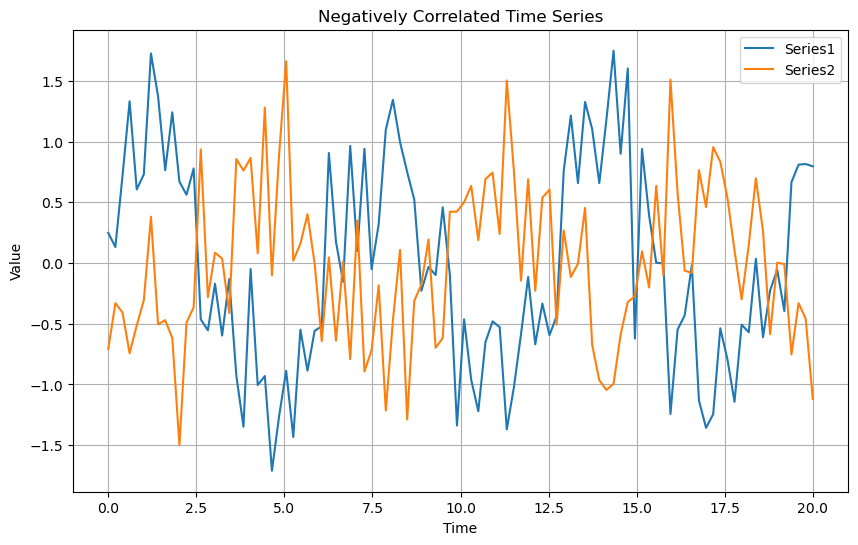

             Time   Series1   Series2
Time     1.000000 -0.098712  0.101757
Series1 -0.098712  1.000000 -0.620468
Series2  0.101757 -0.620468  1.000000


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Generate a time series
time_points = 100
x = np.linspace(0, 20, time_points)
y1 = np.sin(x) + np.random.normal(scale=0.5, size=time_points)

# Generate another time series that is negatively correlated with the first one
strength = -0.6
y2 = strength * np.sin(x) + np.random.normal(scale=0.5, size=time_points)

# Create a DataFrame
df = pd.DataFrame({'Time': x, 'Series1': y1, 'Series2': y2})

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Series1'], label='Series1')
plt.plot(df['Time'], df['Series2'], label='Series2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Negatively Correlated Time Series')
plt.legend()
plt.grid(True)
plt.show()

df.corr()

df
print(df.corr())


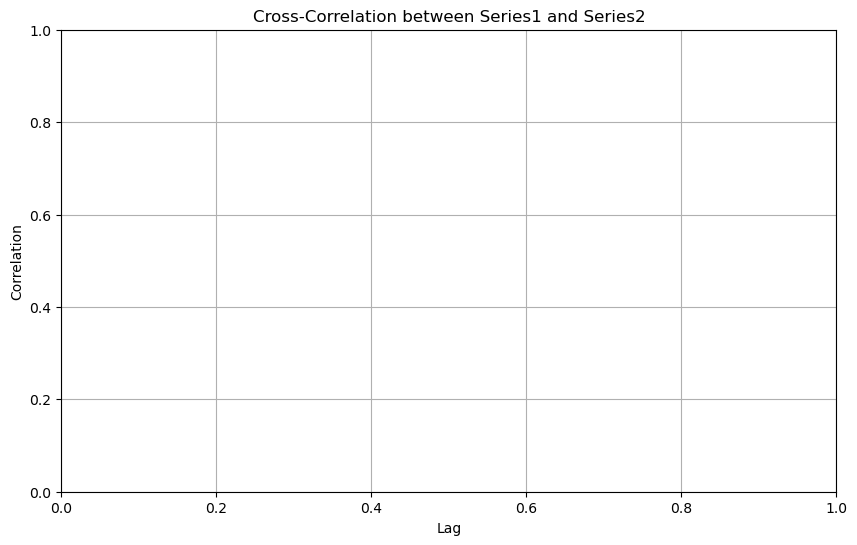

(0, -0.6204675088015525)

In [9]:
from statsmodels.tsa.stattools import ccf

# Calculate cross-correlation for various lags
def cross_correlation(series1, series2, max_lag):
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    for lag in lags:
        if lag < 0:
            correlation = np.corrcoef(series1[:lag], series2[-lag:])[0, 1]
        elif lag > 0:
            correlation = np.corrcoef(series1[lag:], series2[:-lag])[0, 1]
        else:
            correlation = np.corrcoef(series1, series2)[0, 1]
        correlations.append(correlation)
    return lags, correlations

# Define maximum lag to consider
max_lag = 20

# Compute cross-correlation
lags, correlations = cross_correlation(df['Series1'], df['Series2'], max_lag)

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Cross-Correlation between Series1 and Series2')
plt.grid(True)
plt.show()

# Find the lag with maximum negative correlation
max_negative_corr_lag = lags[np.argmin(correlations)]
max_negative_corr = min(correlations)

max_negative_corr_lag, max_negative_corr
